<a href="https://colab.research.google.com/github/namita0210/Text-Sentiment-Classifier/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from kagglehub import dataset_download
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from scipy.sparse import hstack
import string
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lemmy
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Embedding, Dense, Flatten
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') # It uses the perceptron algorithm to assign parts of speech to words based on context.
nltk.download('punkt') # for tokenizing text to words or sentences
nltk.download('stopwords') # populary removed words
nltk.download('wordnet') #dictionary of words to reduce them to their base form : lemmatize
nltk.download('averaged_perceptron_tagger')  # For POS tagging
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Done")

C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nnn866470\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_dat

Done


In [2]:
# Download latest version
path = dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\nnn866470\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


In [3]:
train_df = pd.read_csv(path + '/twitter_training.csv' , header = None)
val_df = pd.read_csv(path + '/twitter_validation.csv', header = None)
train_df.columns = ['id','title','sentiment','text']
val_df.columns = ['id','title','sentiment','text']

print(f'''Train Df Shape : {train_df.shape}
Validation Df Shape : {val_df.shape}''')

Train Df Shape : (74682, 4)
Validation Df Shape : (1000, 4)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   title      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
nulls =74682-73996
nulls

686

A very small number of null values in a large dataset, so we can drop these rows.

In [6]:
train_df.dropna(subset=['text'], inplace=True)

In [7]:
train_df.head(2)

,id,title,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [8]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   title      1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [9]:
val_df.head(2)

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


In [10]:
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

Checking for class imbalance

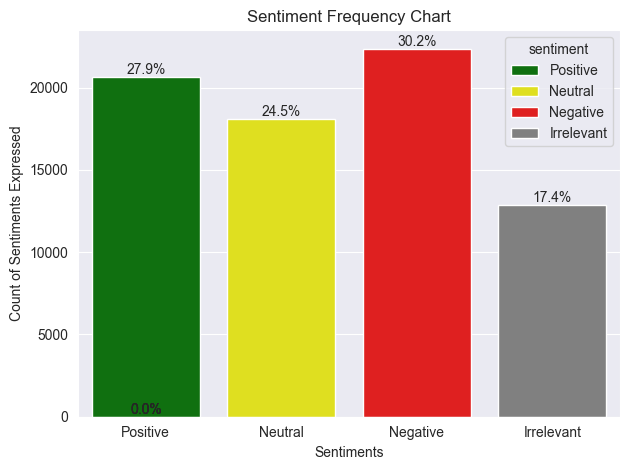

In [11]:
color = {'Positive':'Green', 'Neutral':'Yellow', 'Irrelevant':'Grey','Negative':'Red'}
ax = sns.countplot(x='sentiment', data=train_df
                   ,order=['Positive','Neutral','Negative','Irrelevant']
                  ,hue='sentiment'
                  ,legend=True
                  ,palette=color)
total = len(train_df['sentiment'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')


plt.xlabel('Sentiments')
plt.ylabel('Count of Sentiments Expressed')
plt.title('Sentiment Frequency Chart')
plt.tight_layout()
plt.show()

There is a minimal class imbalance, so no need to go with resampling methods. We will use algorithms like Logistic Regression with balanced weights, random forest, and xgboost that work well with imbalance and we will evaluate with precision and recall to get a holistic evaluation which is not affected by the class imbalance

### Clean the Data

In [12]:
def clean(text):

    stop_words = set(stopwords.words('english')) #stopwords is a class whose object is words and english is it's argument which is stored in a variable called stop_words

    lm = lemmy() #lm is an instance of the lemmy() class
    text=text.lower() #lowercase

    no_punct = re.sub(r'[^a-z\s]','',text) #remove punctuation, digits

    words = word_tokenize(no_punct) #split text into words, returns a list

    words = [i for i in words if i not in stop_words] #remove stopwords

    pos_tags = nltk.pos_tag(words) # returns a tuple (word, pos tag)

    words = [
    lm.lemmatize(word, pos='v') if tag.startswith('V') else  # If tag starts with 'V', treat as verb
    lm.lemmatize(word, pos='n') if tag.startswith('N') else  # If tag starts with 'N', treat as noun
    lm.lemmatize(word, pos='a') if tag.startswith('R') else  # If tag starts with 'R', treat as adjective/adverb
    lm.lemmatize(word)  # Default to noun if no match
    for word, tag in pos_tags
    ] #lemmatize returns a string

    clean_words = ' '.join(words) # joins the words in the list seprated by a space

    return clean_words #This is a string.

In [13]:
train_df['text']=train_df['text'].apply(clean)

In [14]:
train_df.head()

,id,title,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder


### BOW

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from category_encoders import TargetEncoder

In [16]:
# Step 1: Get the data and ensure proper tokenization
train_df = train_df.sample(frac=1) # Shuffle the data

In [17]:
bow_test = val_df.head(10) # It has the target column
bow_train = train_df.head(20)

In [18]:
bow_test.head(3)

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [19]:
y_real_bow = val_df.head(10)['sentiment']

In [20]:
bow_train['sentiment'].unique()

array(['Positive', 'Neutral', 'Irrelevant', 'Negative'], dtype=object)

In [21]:
bow_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 37792 to 51470
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20 non-null     int64 
 1   title      20 non-null     object
 2   sentiment  20 non-null     object
 3   text       20 non-null     object
dtypes: int64(1), object(3)
memory usage: 800.0+ bytes


In [22]:
target_encoder = TargetEncoder()

In [23]:
# Step 3 - Vectorization
#bow_train.loc[:, 'text_joined'] = bow_train['text'].str.join(' ') # Join tokens back into strings (required by CountVectorizer)
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(bow_train['text'])

In [24]:
X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 176 stored elements and shape (20, 158)>

<b>In TARGET ENCODING fit_transform() combines two steps:</b>`-

- fit(X, y):
    It learns the mapping from each category in X to the mean of the target variable y.

- transform(X):
    It replaces each category in X with the corresponding mean value that it learned during fit.

<b>So fit_transform(X, y):</b>

- First learns the mean of y for each category in X.

- Then replaces the category with that mean.

In [25]:
# Step 3.1 - Combine the bow matrix with the other features in the dataframe
categorical_feature_0 = target_encoder.fit_transform(bow_train['title'].values.reshape(-1, 1), bow_train['sentiment'])
X_bow_combo = hstack([categorical_feature_0, X_bow])
print(type(X_bow_combo))

<class 'scipy.sparse._coo.coo_matrix'>


Initialize Normalizer to scale the sparse matrix

In [26]:
normalizer = Normalizer(norm='l2')

In [27]:
X_normalized = normalizer.transform(X_bow_combo)

Logistic Regression

In [33]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_normalized, bow_train['sentiment'])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [34]:
def bow_method(df,vectorizer):
    df.drop(['sentiment'], axis=1, inplace=True) #remove target col
    df.drop(['id'], axis=1, inplace=True) #Drop ID column
    df['text'] = df['text'].apply(clean) #clean
    X_bow = vectorizer.transform(df['text'])
    categorical_feature_0 = target_encoder.transform(df['title'].values.reshape(-1, 1))
    X_bow_combo = hstack([categorical_feature_0, X_bow])
    return X_bow_combo

In [35]:
X_bow_test_combo=bow_method(bow_test,vectorizer)

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_16572\698730523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['sentiment'], axis=1, inplace=True) #remove target col
C:\Users\nnn866470\AppData\Local\Temp\ipykernel_16572\698730523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['id'], axis=1, inplace=True) #Drop ID column
C:\Users\nnn866470\AppData\Local\Temp\ipykernel_16572\698730523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Visualize the correlation in the sparse and normalized matrix

In [36]:
original_feature_names = list(vectorizer.get_feature_names_out())
new_feature_names = original_feature_names + ['title']

In [37]:
cov = pd.DataFrame(X_normalized.toarray(), columns=new_feature_names)

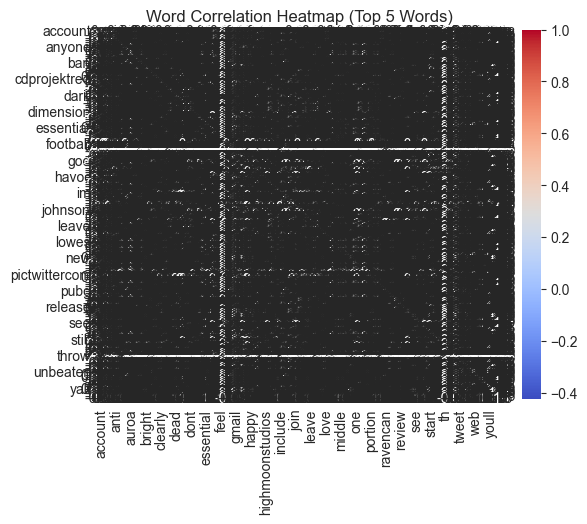

In [38]:
corr = cov.corr()

# Heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Word Correlation Heatmap (Top 5 Words)")
plt.show()

In [31]:
y_bow_pred = model.predict(X_bow_test_combo)

In [32]:
print("Val: ",len(bow_test['title'].unique()))
print("Train: ",len(bow_train['title'].unique()))

Val:  10
Train:  12


In [33]:
print(f"Train BoW shape: {X_bow_combo.shape}")  # Expected: (n_samples, 222)
print(f"Test BoW shape: {X_bow_test_combo.shape}")    # Expected: (n_samples, 222)

Train BoW shape: (20, 158)
Test BoW shape: (10, 158)


In [34]:
print(y_bow_pred)

['Positive' 'Negative' 'Neutral' 'Neutral' 'Neutral' 'Positive' 'Neutral'
 'Neutral' 'Neutral' 'Positive']


In [35]:
bow_test['LR Model Predictions'] = y_bow_pred

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_1772\1857000988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['LR Model Predictions'] = y_bow_pred


In [36]:
bow_test['Real Labels'] = y_real_bow

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_1772\3649113147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['Real Labels'] = y_real_bow


In [37]:
bow_test

,title,text,LR Model Predictions,Real Labels
0,Facebook,mention facebook struggle motivation go run da...,Positive,Irrelevant
1,Amazon,bbc news amazon bos jeff bezos reject claim co...,Negative,Neutral
2,Microsoft,microsoft pay word function poorly samsungus c...,Neutral,Negative
3,CS-GO,csgo matchmaking full closet hack truly awful ...,Neutral,Negative
4,Google,president slap american face really commit unl...,Neutral,Neutral
5,FIFA,hi eahelp ive madeleine mccann cellar past yea...,Positive,Negative
6,MaddenNFL,thank eamaddennfl new te austin hooper orange ...,Neutral,Positive
7,TomClancysRainbowSix,rocket league sea thief rainbow six siege love...,Neutral,Positive
8,AssassinsCreed,as still kneedeep assassin creed odyssey way a...,Neutral,Positive
9,CallOfDuty,fix jesus please fix world go playstation askp...,Positive,Negative


Decision Tree

In [38]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)

In [39]:
clf.fit(X_bow_combo, bow_train['sentiment'])

DecisionTreeClassifier(random_state=42)

In [40]:
y_pred_dt = clf.predict(X_bow_test_combo)

In [41]:
bow_test['Decision Tree Prediction'] = y_pred_dt

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_1772\2384182960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['Decision Tree Prediction'] = y_pred_dt


In [42]:
bow_test

,title,text,LR Model Predictions,Real Labels,Decision Tree Prediction
0,Facebook,mention facebook struggle motivation go run da...,Positive,Irrelevant,Negative
1,Amazon,bbc news amazon bos jeff bezos reject claim co...,Negative,Neutral,Negative
2,Microsoft,microsoft pay word function poorly samsungus c...,Neutral,Negative,Negative
3,CS-GO,csgo matchmaking full closet hack truly awful ...,Neutral,Negative,Neutral
4,Google,president slap american face really commit unl...,Neutral,Neutral,Negative
5,FIFA,hi eahelp ive madeleine mccann cellar past yea...,Positive,Negative,Negative
6,MaddenNFL,thank eamaddennfl new te austin hooper orange ...,Neutral,Positive,Negative
7,TomClancysRainbowSix,rocket league sea thief rainbow six siege love...,Neutral,Positive,Negative
8,AssassinsCreed,as still kneedeep assassin creed odyssey way a...,Neutral,Positive,Negative
9,CallOfDuty,fix jesus please fix world go playstation askp...,Positive,Negative,Negative


Random Forest

In [43]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=42)

In [44]:
rf_model.fit(X_bow_combo, bow_train['sentiment'])

RandomForestClassifier(n_estimators=5, random_state=42)

In [45]:
y_pred_rf = rf_model.predict(X_bow_test_combo)

In [46]:
bow_test['Random Forest Predictions'] = y_pred_rf

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_1772\3278068601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['Random Forest Predictions'] = y_pred_rf


In [47]:
bow_test.head()

,title,text,LR Model Predictions,Real Labels,Decision Tree Prediction,Random Forest Predictions
0,Facebook,mention facebook struggle motivation go run da...,Positive,Irrelevant,Negative,Negative
1,Amazon,bbc news amazon bos jeff bezos reject claim co...,Negative,Neutral,Negative,Negative
2,Microsoft,microsoft pay word function poorly samsungus c...,Neutral,Negative,Negative,Negative
3,CS-GO,csgo matchmaking full closet hack truly awful ...,Neutral,Negative,Neutral,Neutral
4,Google,president slap american face really commit unl...,Neutral,Neutral,Negative,Negative


Naive Bayes

In [48]:
model_nb = MultinomialNB()

In [51]:
model_nb.fit(X_bow_combo, bow_train['sentiment'])

MultinomialNB()

In [53]:
y_pred_nb = model_nb.predict(X_bow_test_combo)

In [54]:
y_pred_nb

array(['Positive', 'Negative', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive'],
      dtype='<U10')

In [55]:
bow_test['Naive Bayes'] = y_pred_nb

C:\Users\nnn866470\AppData\Local\Temp\ipykernel_1772\3461553657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_test['Naive Bayes'] = y_pred_nb


In [56]:
bow_test

,title,text,LR Model Predictions,Real Labels,Decision Tree Prediction,Random Forest Predictions,Naive Bayes
0,Facebook,mention facebook struggle motivation go run da...,Positive,Irrelevant,Negative,Negative,Positive
1,Amazon,bbc news amazon bos jeff bezos reject claim co...,Negative,Neutral,Negative,Negative,Negative
2,Microsoft,microsoft pay word function poorly samsungus c...,Neutral,Negative,Negative,Negative,Negative
3,CS-GO,csgo matchmaking full closet hack truly awful ...,Neutral,Negative,Neutral,Neutral,Neutral
4,Google,president slap american face really commit unl...,Neutral,Neutral,Negative,Negative,Negative
5,FIFA,hi eahelp ive madeleine mccann cellar past yea...,Positive,Negative,Negative,Negative,Positive
6,MaddenNFL,thank eamaddennfl new te austin hooper orange ...,Neutral,Positive,Negative,Negative,Negative
7,TomClancysRainbowSix,rocket league sea thief rainbow six siege love...,Neutral,Positive,Negative,Negative,Negative
8,AssassinsCreed,as still kneedeep assassin creed odyssey way a...,Neutral,Positive,Negative,Negative,Negative
9,CallOfDuty,fix jesus please fix world go playstation askp...,Positive,Negative,Negative,Negative,Positive


## Evaluation

Evaluating Logistic Regression

In [57]:
from sklearn.metrics import precision_score
precision_per_class_bow = precision_score(y_real_bow, y_bow_pred, average=None)
print(f"Precision per class: {precision_per_class_bow}")

Precision per class: [0.         0.         0.16666667 0.        ]


C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_real_bow, y_bow_pred))


              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00         1
    Negative       0.00      0.00      0.00         4
     Neutral       0.17      0.50      0.25         2
    Positive       0.00      0.00      0.00         3

    accuracy                           0.10        10
   macro avg       0.04      0.12      0.06        10
weighted avg       0.03      0.10      0.05        10



C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Evaluating Decision Tree

In [59]:
print("Accuracy:", accuracy_score(y_real_bow, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_real_bow, y_pred_dt))

Accuracy: 0.3

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00         1
    Negative       0.33      0.75      0.46         4
     Neutral       0.00      0.00      0.00         2
    Positive       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.08      0.19      0.12        10
weighted avg       0.13      0.30      0.18        10



C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Evaluating Random Forest

In [60]:
print("Accuracy:", accuracy_score(y_real_bow, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_real_bow, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_real_bow, y_pred_rf))

Accuracy: 0.3

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00         1
    Negative       0.33      0.75      0.46         4
     Neutral       0.00      0.00      0.00         2
    Positive       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.08      0.19      0.12        10
weighted avg       0.13      0.30      0.18        10

Confusion Matrix:
 [[0 1 0 0]
 [0 3 1 0]
 [0 2 0 0]
 [0 3 0 0]]


C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Evaluating Naive Bayes

In [61]:
print("Accuracy:", accuracy_score(y_real_bow, y_pred_nb))
print(classification_report(y_real_bow, y_pred_nb))

Accuracy: 0.1
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00         1
    Negative       0.17      0.25      0.20         4
     Neutral       0.00      0.00      0.00         2
    Positive       0.00      0.00      0.00         3

    accuracy                           0.10        10
   macro avg       0.04      0.06      0.05        10
weighted avg       0.07      0.10      0.08        10



C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

### TF - IDF

In [141]:
vectorizer = TfidfVectorizer()

In [142]:
X = vectorizer.fit_transform(train_df['text'])

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
X

In [ ]:
type(X)

In [ ]:
print(X)

Most of the elements in a TF-IDF matrix are typically zero (because most words don't appear in most documents).  Storing all those zeros would be extremely inefficient.  Sparse matrix formats like COO, Compressed Sparse Row (CSR), and Compressed Sparse Column (CSC) only store the non-zero values and their indices, saving a huge amount of memory.

In [ ]:
tf_idf_matrix = X

In [ ]:
sentiment_map = {
    'Positive': 3,
    'Neutral': 1,
    'Irrelevant': 2,
    'Negative': 0
}

In [ ]:
train_df['sentiment'] = train_df['sentiment'].map(sentiment_map)

In [ ]:
len(train_df['title'].unique())

In [ ]:
le = LabelEncoder()
train_df['title'] = le.fit_transform(train_df['title'])

In [ ]:
train_df.head(2)

In [ ]:
target = train_df['sentiment']

In [ ]:
independent_variables = ['id','title']
features = train_df[independent_variables].values

In [ ]:
features.values

In [ ]:
print(f'''dimension = {features.values.ndim}
shape = {features.values.shape}''')

In [ ]:
print(f'''dimension = {tf_idf_matrix.ndim}
shape = {tf_idf_matrix.shape}''')

In [ ]:
features = hstack((features,tf_idf_matrix))

In [ ]:
features

#Training a neural network to predict the sentiment based on the independent variables in my dataframe.

In [ ]:
num_categories = features.shape[1]
print(num_categories)

In [ ]:
embedding_dim = 5

In [ ]:
nn = Sequential()

In [ ]:
nn.add(Embedding(input_dim=num_categories,  # 32 categories
                    output_dim=embedding_dim,  # Dimension of the embedding vector (e.g., 5)
                    input_length=1))

In [ ]:
nn.add(Flatten())

In [ ]:
nn.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
nn.add(Dense(32, activation='relu'))

In [ ]:
nn.add(Dense(4, activation='softmax'))  # Output layer with 4 classes (0-3)

In [ ]:
# Compile the model
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
nn.summary()

In [ ]:
nn.fit(features, target, epochs=10, batch_size=32)

In [ ]:
import numpy as np

A = np.random.randn(3,4)
B = np.random.randn(4,3)

print(f''' A : {type(A)}
      B:  {type(B)}
      A multiplied by B : {A@B}''')